# 6.1 Классификация.Соискатели

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендаьельных систем](https://habrahabr.ru/company/dca/blog/281066/)

## kNN - ближайшие соседи (15 баллов)

Рассмотрим задачу из соревнования [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge).

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import scale

In [2]:
df = pd.read_csv('../../data/amazon.csv.gz')
df.head()
# ACTION - это целевой признак

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Обратим внимание, что выборка не сбалансированная. В качестве метрики качества будем использовть [f1-score](https://en.wikipedia.org/wiki/F1_score). 
$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

0.9421099209618847


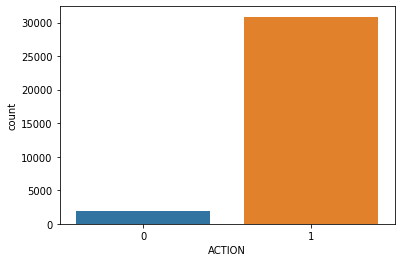

In [3]:
print(df['ACTION'].mean())
sns.countplot('ACTION', data=df)

In [4]:
# число значений у признаков
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


# Baseline (4 балла)

Сразу проверим как ведет себя kNN на неподготовленных данных и без тюнинга. Зафиксируйте `n_neighbors=5`, `p=2`. 

- создайте экземпляр `KNeighborsClassifier` с указанными параметрами, обучите его методом `fit` и предскажите значения `predict` для треничровчных данных `X_test`.
- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Обратите внимание на confusion matrix. Какой вывод вы можете сделать из неё? Вспомните лекцию и значение ошибок 1 и 2 рода.

In [5]:
X= df.drop(['ACTION'],axis=1)
y= df['ACTION']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

In [7]:
clf = KNeighborsClassifier(n_neighbors=5, p=2)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [8]:
y_pred = clf.predict(X_test).astype('int')

??? y_pred является на основе какого фолда?

??? Можно ли как то дообучать модели на новых данных или только обучать заново?

In [9]:
#отчет классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.09      0.14       614
           1       0.95      0.99      0.97     10200

    accuracy                           0.94     10814
   macro avg       0.64      0.54      0.55     10814
weighted avg       0.91      0.94      0.92     10814



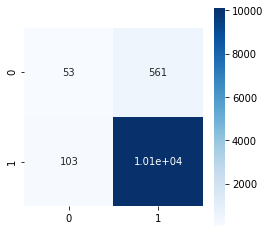

In [10]:
plt.figure(figsize=(4,4)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

Выводы:
- плотность 0 очень низкая, соответственно f1 тоже низкая
- точность предсказания 0 очень нищкая

При фиксированном `n_neighbors=10` проверьте значение метрики на кроссвалидации на 5-фолдах для разных значений `p` из `(1,2,4,6)`. При каком значение `p` метрика достигает максимума?

При кроссвалидации у вас будет получаться N разных значений метрики. Выводите среднее значение и стандартное отклонение.

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
clf = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

%time scores = cross_val_score(clf, X, y, cv=cv)
print("Accuracy: {}".format(scores.mean()))

CPU times: user 3.01 s, sys: 2.28 ms, total: 3.01 s
Wall time: 3.01 s
Accuracy: 0.938570053032523


In [13]:
params = {
            "n_neighbors": [10], 
            "p": [1,2,4,6]
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(KNeighborsClassifier(), params, cv=cv, verbose=2,n_jobs=-1)                    

%time search.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 241 ms, sys: 44.7 ms, total: 285 ms
Wall time: 26.1 s


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   26.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [10], 'p': [1, 2, 4, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [14]:
search.cv_results_

{'mean_fit_time': array([0.10611944, 0.10956402, 0.11333261, 0.09240627]),
 'std_fit_time': array([0.01329   , 0.00879315, 0.02099404, 0.00798053]),
 'mean_score_time': array([1.64788485, 1.4118433 , 7.78512068, 6.7757103 ]),
 'std_score_time': array([0.07182745, 0.04476743, 0.6398913 , 0.70059022]),
 'param_n_neighbors': masked_array(data=[10, 10, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_p': masked_array(data=[1, 2, 4, 6],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 10, 'p': 1},
  {'n_neighbors': 10, 'p': 2},
  {'n_neighbors': 10, 'p': 4},
  {'n_neighbors': 10, 'p': 6}],
 'split0_test_score': array([0.94003662, 0.93851083, 0.93957888, 0.93957888]),
 'split1_test_score': array([0.93927373, 0.93866341, 0.9394263 , 0.93896857]),
 'split2_test_score': array([0.94095209, 0.94140983, 0.94202014, 0.9423253 ]),
 'split3_test_score': 

In [15]:
round(search.cv_results_['split0_test_score'].mean(),8)

0.9394263

BEST: score=0.9403399785072131, params={'n_neighbors': 10, 'p': 4}


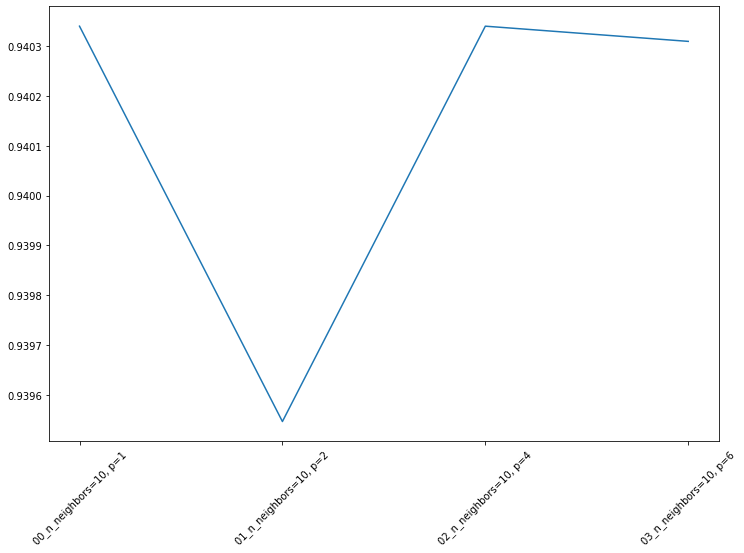

In [16]:
x_ticks = ["{:02d}_n_neighbors={}, p={}".format(i, p['n_neighbors'], p['p']) for i,p in enumerate(search.cv_results_['params'])]

plt.figure(figsize=(12,8))
plt.plot(x_ticks, search.cv_results_['mean_test_score'])
_ =plt.xticks(rotation=45)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

Отчет классификации стал еще хуже:

              precision    recall  f1-score   support

           0       0.25      0.03      0.05       614
           1       0.94      0.99      0.97     10200

    accuracy                           0.94     10814
   macro avg       0.60      0.51      0.51     10814
weighted avg       0.91      0.94      0.92     10814



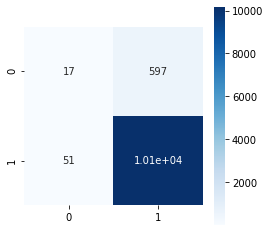

In [17]:
clf = KNeighborsClassifier(n_neighbors=search.best_params_['n_neighbors'], p=search.best_params_['p'])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test).astype('int')

print(classification_report(y_test, y_pred))

plt.figure(figsize=(4,4))
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g')

# Счетчики (6 баллов)

Очевидно, что предсказывать лейбл объекта, используя при этом метрический алгоритм на категориальных признаках - это ОЧЕНЬ странная затея. Не удивительно что качество ужасное. Необходимо каким-то образом заменить категориальные признаки вещественными:

- OneHotEncoding - это когда для каждого признака создают другие N бинарных признаков, где N - это количество категорий у категориального признака.
- Счетчики - об это написано в статье http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx.

Мы реализуем алгоритм Счетчиков. Его нет в sklearn, поэтому придется реализовать самому. 

Для каждого категориального признака создайте 3 других признака:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

Обучение надо проводить только по новым признакам. Изначальные мы не используем.

Подсказка - вам нужно для каждой колонки посчитать 2 аггрегации - сумму и количество. Для замены конкретного значения посчитанным используйте функцию apply над датафреймом. Простое решение займет около 10 строк кода.

![](http://images6.fanpop.com/image/photos/38600000/taiga-iamyourenemy-38620719-282-160.gif)

In [18]:
df5 = df.iloc[41:56][['ACTION','ROLE_FAMILY']]
df5

,ACTION,ROLE_FAMILY
41,0,118638
42,1,290919
43,1,308574
44,1,308574
45,1,118295
46,1,290919
47,1,118643
48,1,118960
49,1,19721
50,1,119221


In [19]:
XX= df5.drop(['ACTION'],axis=1)
yy= df5['ACTION']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(XX, yy, random_state=42, test_size=0.3, stratify=yy)

In [21]:
X_train

,ROLE_FAMILY
55,19721
43,308574
50,119221
42,290919
51,118331
54,290919
47,118643
53,290919
48,118960
44,308574


In [22]:
X_train_split = int(X_train.shape[0]*0.7)
X_train_split

7

In [23]:
X_train.iloc[:X_train_split]

,ROLE_FAMILY
55,19721
43,308574
50,119221
42,290919
51,118331
54,290919
47,118643


In [24]:
X_train.iloc[X_train_split:]

,ROLE_FAMILY
53,290919
48,118960
44,308574


??? Что делать, есть значение(308574) категориального признака не встречалось в части тренеровочной выборки, где подсчет мы производили на основании целевого признака?

??? Может в counts считать не количетсво а процентное соотношение? Ведь в тесте меньше данных, в итоге другие будут counts, т.е. разного масштаба.

In [25]:
def CountAndSuccCalc(df, df_counts, col_name):
    
    c = df[col_name].apply(lambda value: df_counts[value].sum()) #сумма встречающихся значений 0 и 1
    s = df[col_name].apply(lambda value: df_counts[value].iloc[1]) #количество значения при у=1
    f = (s+1)/(c+2)
    return [c,s,f]

In [36]:
def CountAndSuccMain (df, train_part_by_target_size=0.7, y_name = 'ACTION'):
    '''
    train_part_by_target_size - пропорция от общего числа тренеровочной выборки, у которой counts и successes будут 
                    строится по целевому признаку, остальные части на основании train_part_by_target_size.
    '''
    
    #Создаю новые признаки и наполняю их NaN, далее буду считать точные значения
    col_names = df.columns
    for col_name in col_names:
        if col_name == y_name:
            continue
        df[col_name+'_count'], df[col_name+'_successes'], df[col_name+'_flattened'] = list(3*[np.NaN])

    X_train, X_test, y_train, y_test = train_test_split(df.drop([y_name],axis=1), df[y_name], random_state=42, test_size=0.3, stratify=df[y_name])
    
    X_train_spliter = int(X_train.shape[0]*train_part_by_target_size)# Разделитель тренеровочной выборки на 2 части
    X_train_by_target = X_train.iloc[:X_train_spliter] # Новые признаки будут строиться на основе целевого
    X_train = X_train.iloc[X_train_spliter:] # Новые признаки будут строиться на основе X_train_by_target
       
    #Счетчики для первой части тренеровочной выборки
    for col_name in col_names:
        if col_name == y_name:
            continue
                    #формирую новую выборку с целевой переменной,на основе индексов train_test_split, чтобы произвести рассчеты    
        df_counts = pd.DataFrame(index=X_train_by_target.index, data=df).groupby([y_name,col_name])[col_name].count().unstack().fillna(0)# группирую данные в таблицу, где именования столбцов это уникальные значения col_name, а в строках количество повторений при у = [0,1] 
        X_train_by_target[col_name+'_count'], X_train_by_target[col_name+'_successes'], X_train_by_target[col_name+'_flattened'] = CountAndSuccCalc(X_train_by_target,df_counts,col_name)  
    
    #Счетчики на основе первой части тренеровочной выборки
    for col_name in col_names:
        if col_name == y_name:
            continue
        for value in X_train[col_name].unique():#Счетчики для второй части тренеровочной выборки на основе первой части     
            if value in X_train_by_target[col_name].values: # Если в первой части тренеровочной выборки существует значение из второй части тренеровочной выборки
                X_train.loc[X_train[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']][:1].values[0]                
        
        for value in X_test[col_name].unique(): #Счетчики для тестовой выборки на основе первой части тренеровочной выборки
            if value in X_train_by_target[col_name].values: # Если в первой части тренеровочной выборки существует значение из второй части тренеровочной выборки
                X_test.loc[X_test[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']][:1].values[0]                
          
    
    #print('------------ train_part_one:\n\n{}'.format(X_train_by_target))
    #print('\n------------ train_part_two:\n\n{}'.format(X_train))
    #print('\n------------ test:\n\n{}'.format(X_test))
    X_train = pd.concat([X_train_by_target,X_train])
    return X_train, X_test, y_train, y_test

??? Есть инструмент дебага в ноутбуке?

??? Почему df5 заменяется? он же внутри процедуры

In [37]:
df5 = df.iloc[41:56][['ACTION','ROLE_FAMILY']]
df5

,ACTION,ROLE_FAMILY
41,0,118638
42,1,290919
43,1,308574
44,1,308574
45,1,118295
46,1,290919
47,1,118643
48,1,118960
49,1,19721
50,1,119221


In [38]:
X_train, X_test, y_train, y_test = CountAndSuccMain(df5)

In [48]:
X_train, X_test, y_train, y_test = CountAndSuccMain(df)

In [49]:
X_train.isnull().sum()

RESOURCE                         0
MGR_ID                           0
ROLE_ROLLUP_1                    0
ROLE_ROLLUP_2                    0
ROLE_DEPTNAME                    0
ROLE_TITLE                       0
ROLE_FAMILY_DESC                 0
ROLE_FAMILY                      0
ROLE_CODE                        0
RESOURCE_count                1265
RESOURCE_successes            1265
RESOURCE_flattened            1265
MGR_ID_count                   431
MGR_ID_successes               431
MGR_ID_flattened               431
ROLE_ROLLUP_1_count              1
ROLE_ROLLUP_1_successes          1
ROLE_ROLLUP_1_flattened          1
ROLE_ROLLUP_2_count              3
ROLE_ROLLUP_2_successes          3
ROLE_ROLLUP_2_flattened          3
ROLE_DEPTNAME_count             12
ROLE_DEPTNAME_successes         12
ROLE_DEPTNAME_flattened         12
ROLE_TITLE_count                10
ROLE_TITLE_successes            10
ROLE_TITLE_flattened            10
ROLE_FAMILY_DESC_count         291
ROLE_FAMILY_DESC_suc

In [50]:
X_test.isnull().sum()

RESOURCE                         0
MGR_ID                           0
ROLE_ROLLUP_1                    0
ROLE_ROLLUP_2                    0
ROLE_DEPTNAME                    0
ROLE_TITLE                       0
ROLE_FAMILY_DESC                 0
ROLE_FAMILY                      0
ROLE_CODE                        0
RESOURCE_count                1802
RESOURCE_successes            1802
RESOURCE_flattened            1802
MGR_ID_count                   679
MGR_ID_successes               679
MGR_ID_flattened               679
ROLE_ROLLUP_1_count              5
ROLE_ROLLUP_1_successes          5
ROLE_ROLLUP_1_flattened          5
ROLE_ROLLUP_2_count             14
ROLE_ROLLUP_2_successes         14
ROLE_ROLLUP_2_flattened         14
ROLE_DEPTNAME_count             20
ROLE_DEPTNAME_successes         20
ROLE_DEPTNAME_flattened         20
ROLE_TITLE_count                25
ROLE_TITLE_successes            25
ROLE_TITLE_flattened            25
ROLE_FAMILY_DESC_count         450
ROLE_FAMILY_DESC_suc

In [51]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
pass

Проверьте какое качество теперь получается на кроссвалидации для новых данных.

In [52]:
clf = KNeighborsClassifier(n_neighbors=5, p=2)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [53]:
y_pred = clf.predict(X_test).astype('int')

In [54]:
#отчет классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.10      0.16       569
           1       0.95      0.99      0.97      9262

    accuracy                           0.94      9831
   macro avg       0.68      0.55      0.56      9831
weighted avg       0.92      0.94      0.92      9831



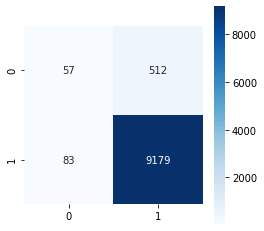

In [55]:
plt.figure(figsize=(4,4)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество.

# Co-co-co-combo (5 баллов)

Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [210]:
df_combo = df.copy()
# ТУТ ВАШ КОД

In [211]:
def generate_pair_features(df, y_name, separator = '#'):

    columns_df = list(df.columns)
    columns_df.remove(y_name)

    for col_name in columns_df:

        columns_pair = columns_df[:] 
        columns_pair.remove(col_name)
    
        for col_pair_name in columns_pair:
            
            new_col_name = col_name+separator+col_pair_name
            new_col_name_revers = col_pair_name+separator+col_name
            if new_col_name_revers in list(df.columns): #Если столбец с обратной парой уже существует, то пропускаем
                continue
            else:
                df[new_col_name] = df.apply((lambda x: '{}{}{}'.format(x[col_name],separator,x[col_pair_name])), axis=1)
    
    return df

In [212]:
%%time
df_combo = generate_pair_features(df_combo, 'ACTION')

CPU times: user 1min 4s, sys: 71.2 ms, total: 1min 4s
Wall time: 1min 4s


In [213]:
df_combo.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,...,ROLE_DEPTNAME#ROLE_TITLE,ROLE_DEPTNAME#ROLE_FAMILY_DESC,ROLE_DEPTNAME#ROLE_FAMILY,ROLE_DEPTNAME#ROLE_CODE,ROLE_TITLE#ROLE_FAMILY_DESC,ROLE_TITLE#ROLE_FAMILY,ROLE_TITLE#ROLE_CODE,ROLE_FAMILY_DESC#ROLE_FAMILY,ROLE_FAMILY_DESC#ROLE_CODE,ROLE_FAMILY#ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908,...,123472#117905,123472#117906,123472#290919,123472#117908,117905#117906,117905#290919,117905#117908,117906#290919,117906#117908,290919#117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539,...,123125#118536,123125#118536,123125#308574,123125#118539,118536#118536,118536#308574,118536#118539,118536#308574,118536#118539,308574#118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880,...,117884#117879,117884#267952,117884#19721,117884#117880,117879#267952,117879#19721,117879#117880,267952#19721,267952#117880,19721#117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322,...,119993#118321,119993#240983,119993#290919,119993#118322,118321#240983,118321#290919,118321#118322,240983#290919,240983#118322,290919#118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325,...,119569#119323,119569#123932,119569#19793,119569#119325,119323#123932,119323#19793,119323#119325,123932#19793,123932#119325,19793#119325


In [179]:
df_combo.columns

Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE', 'RESOURCE#MGR_ID', 'RESOURCE#ROLE_ROLLUP_1',
       'RESOURCE#ROLE_ROLLUP_2', 'RESOURCE#ROLE_DEPTNAME',
       'RESOURCE#ROLE_TITLE', 'RESOURCE#ROLE_FAMILY_DESC',
       'RESOURCE#ROLE_FAMILY', 'RESOURCE#ROLE_CODE', 'MGR_ID#ROLE_ROLLUP_1',
       'MGR_ID#ROLE_ROLLUP_2', 'MGR_ID#ROLE_DEPTNAME', 'MGR_ID#ROLE_TITLE',
       'MGR_ID#ROLE_FAMILY_DESC', 'MGR_ID#ROLE_FAMILY', 'MGR_ID#ROLE_CODE',
       'ROLE_ROLLUP_1#ROLE_ROLLUP_2', 'ROLE_ROLLUP_1#ROLE_DEPTNAME',
       'ROLE_ROLLUP_1#ROLE_TITLE', 'ROLE_ROLLUP_1#ROLE_FAMILY_DESC',
       'ROLE_ROLLUP_1#ROLE_FAMILY', 'ROLE_ROLLUP_1#ROLE_CODE',
       'ROLE_ROLLUP_2#ROLE_DEPTNAME', 'ROLE_ROLLUP_2#ROLE_TITLE',
       'ROLE_ROLLUP_2#ROLE_FAMILY_DESC', 'ROLE_ROLLUP_2#ROLE_FAMILY',
       'ROLE_ROLLUP_2#ROLE_CODE', 'ROLE_DEPTNAME#ROLE_TITLE',
       'ROLE_DEPTNAME#ROLE_FAMILY_DESC', 'R

In [0]:
data_combo = pd.DataFrame(index=df_combo.index)
for col_name in df_combo.columns:
    if col_name == 'ACTION':
        continue
    # тут ваш код

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество. Не похоже ли это на переобусение?

Внимание! Обучение на этом этапе может быть долгим. На i5 16GB кроссвалидация на 5 фолдах заняла 30 минут!